## TOC:

* [Step 1: Install FRED and Load related packages](#first-bullet)
* [Step 2: Extract Macroeconomic Time Series Data from FRED](#second-bullet)
* [Step 3: Extract Internal KPI Data](#third-bullet)

### Step1: Load related packages and input data <a class="anchor" id="first-bullet"></a>

In [ ]:
!pip install fred

In [ ]:
!pip install fredapi

In [1]:
import numpy as np
import pandas as pd
from fredapi import Fred
from plotnine import *
from mizani.formatters import percent_format
from mizani.breaks import date_breaks
from mizani.formatters import date_format

from docxtpl import DocxTemplate, InlineImage
from docx.shared import Mm
import jinja2


import warnings
warnings.filterwarnings('ignore')


%matplotlib inline
import os
import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
    
    #############################################
## Import Viz packages
#############################################
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.font_manager as font_manager
import matplotlib.ticker as mtick
import matplotlib.colors

#font_manager._rebuild() ## loads custom fonts to python


####### ammpy package to extract data from Redshift cluster

#import ammpy as ap


#############################################
## Define default colour palette and font
#############################################

## Define colour palette (Orange, grey only)
colors = [
        "#FF5A00", #Cascade orange
        "#3E4143", #Darkest gray
        "#808285", #Light gray
        '#B3B4B6', #Lighter gray
        
        ]

## Define colour palette (full range)
colors_full = [
        "#FF5A00", #Cascade orange
        "#009596", #Niagara green
        "#3446C5", #Royal blue
        "#00A1E5", #Seattle sky blue
        "#BB2CAC", #Grape purple
        "#FF71B5", #Rose pink
        "#232F3F", #Squid ink
        "#808285", #Light gray
        ]


cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors) # cmap using colors
cmap2 =\
matplotlib.colors.LinearSegmentedColormap.from_list("", colors_full) # cmap2 using colors_full


## Define default font
#default_font = "Ember Display" # Set default font family to Ember Display
squid_ink_colour = "#232F3F" #Squid ink
light_grey_colour = "#808285" #Light gray




#############################################
## Apply global settings
#############################################

## Global settings
sns.set_style('white') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titleweight='bold')     # bold the title
#plt.rcParams["font.family"] =  default_font # set default font family

plt.rcParams['text.color'] = squid_ink_colour #set default font colour for text as Squid Ink
plt.rcParams['axes.labelcolor'] = light_grey_colour # set default font colour for labels
plt.rcParams['xtick.color'] = light_grey_colour # set default font colour for x axis ticks
plt.rcParams['ytick.color'] = light_grey_colour # set default font colour for y axis ticks

# remove frame border, but keep bottom and left
plt.rcParams['axes.spines.left'] = True  
plt.rcParams['axes.spines.bottom'] = True  
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  


#############################################
## Apply configurable settings 
#############################################

####!!!!!!!!!!!!!! CHANGE BELOW VALUES DEPENDING ON YOUR USE CASE !!!!!!!!!!!!!!####

sns.set_palette(sns.color_palette(colors)) # Choose colors for orange/grey (useful for graphs with 1-3 colours)
#sns.set_palette(sns.color_palette(colors_full)) # Choose colors_full for full range (useful for graphs with 3+ colours)

plt.rcParams["figure.figsize"] = (10, 10) # define default size of graph
plt.rc('axes', titlesize=20)           # fontsize of title
plt.rc('axes', labelsize=15)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

C:\Users\klinb\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\klinb\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


### Step 2: Extract Macroeconomic Time Series Data from FRED<a class="anchor" id="second-bullet"></a>

#### Please use the following link to obtain your own FRED API Key and It is recommended that you use your email to register.

[FRED API Key Registration](https://fredaccount.stlouisfed.org/login/secure/)

In [2]:
fred = Fred(api_key ='96e6f3809dda4265af83733563bb568f')

In [3]:
# FRED Series
fred_list = ['CPIAUCSL','IZ3344','UMCSENT','TOTALSA']
fred_dict = {'CPIAUCSL':'CPI','IZ3344':'Semi_PPI','UMCSENT':'CCI','TOTALSA':'Auto_Sales'}
fred_plot_title=['Consumer Price Index for All Urban Consumers',\
                'Import Price Index (NAICS): Semiconductor and Other Electronic Component Manufacturing',\
                'University of Michigan: Consumer Sentiment',\
                'Total Vehicle Sales']

In [4]:
def FRED_Load_Transform(series_list, start_date = '2021-01-01', end_date='2023-09-01', lag=12):
    
    result = []
    
    for fred_ind in fred_list:
        fred_series = fred.get_series(fred_ind, observation_start=start_date, observation_end=end_date)
        
        fred_df = fred_series.to_frame() 
        fred_df.reset_index(inplace=True)
        col_name = fred_dict[fred_ind]
        fred_df.columns = ['date',col_name]
        col_name_ttm = col_name + '_ttm'
        col_name_ttm_change = col_name_ttm + "_change"
        
        fred_df[col_name_ttm] = fred_df[col_name].shift(lag)
        fred_df[col_name_ttm_change] = (fred_df[col_name] - fred_df[col_name_ttm]) / fred_df[col_name_ttm]
        fred_df.dropna(inplace=True)
        result.append(fred_df)
        
    return result

# plot FRED time series
def FRED_series_plot(fred_list,title='', lag=12):
    
    plot_list = []
    
    for idx,df in enumerate(fred_list):
        fred_plot = ggplot(df, aes(x="date",y=df.columns[-1], fill=df.columns[-1]))\
        + geom_bar(stat = "identity", position = "dodge")\
        + geom_smooth(linetype="dashed")\
        + ggtitle(title[idx])\
        + xlab('Date') + ylab('Change (%) Over Last ' + str(lag) + ' Months') \
        + scale_y_continuous(labels=percent_format()) \
        + theme(legend_title=element_blank(),\
                legend_position = "none",\
                    text=element_text(size=12),\
               axis_text_x=element_text(rotation=90, hjust=1))\
        + scale_fill_gradientn(colors = ["#B3B4B6","#3E4143", "#FF5A00"])
        
        plot_list.append(fred_plot)
        
    return plot_list

In [5]:
fred_list_transformed = FRED_Load_Transform(fred_list)

In [6]:
fred_plot = FRED_series_plot(fred_list_transformed,fred_plot_title)

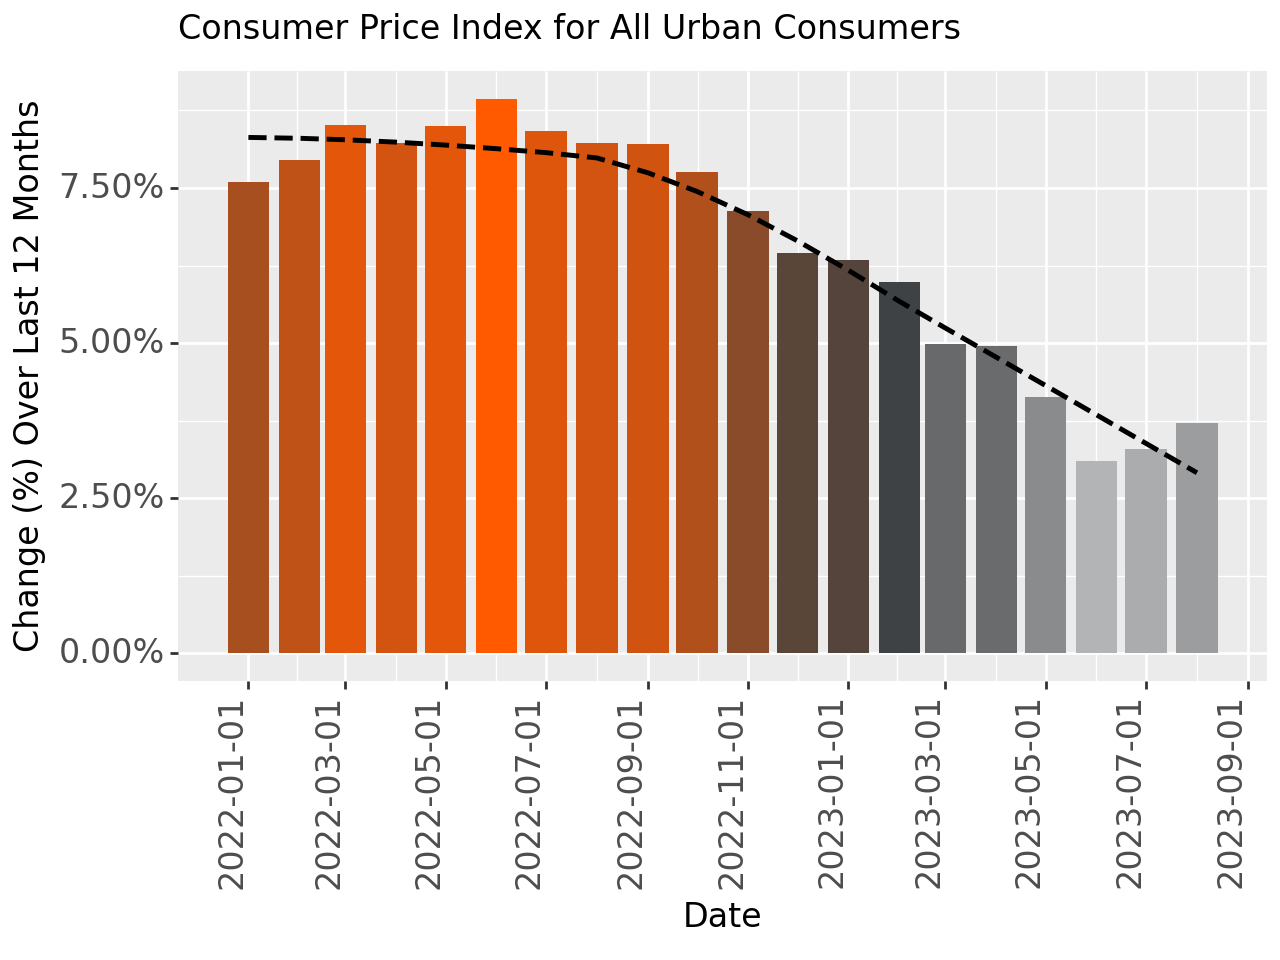

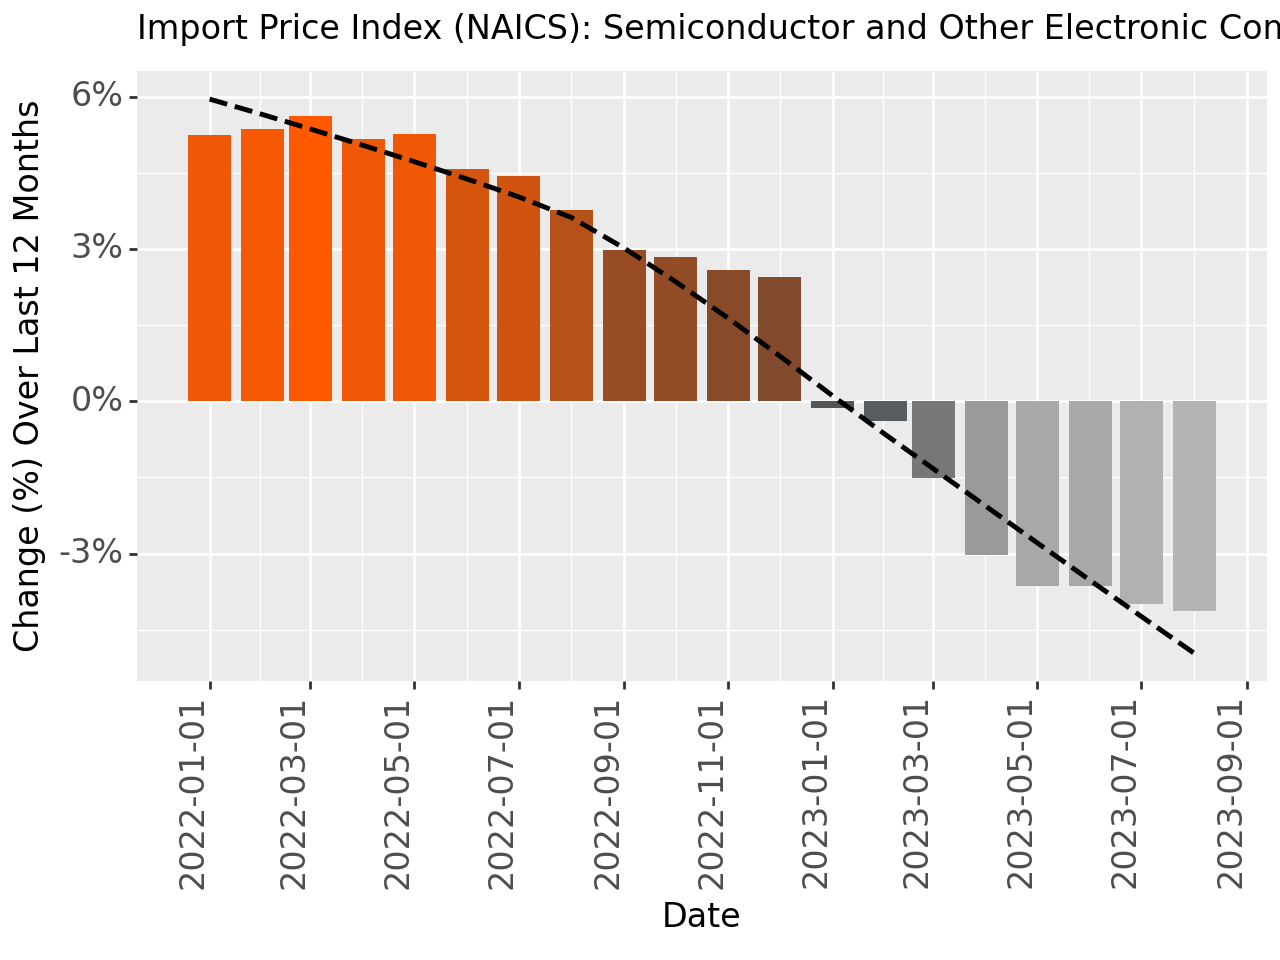

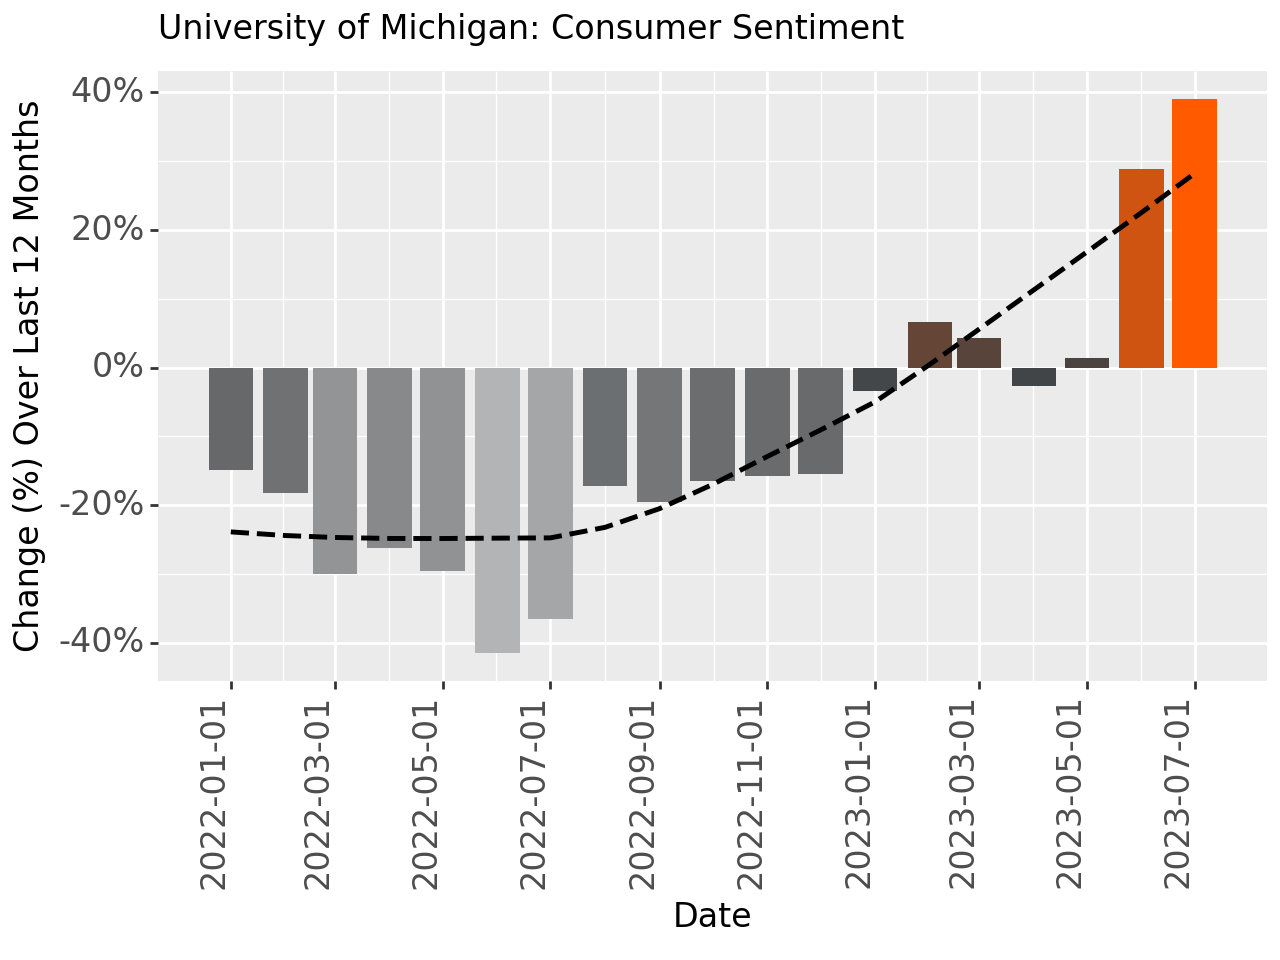

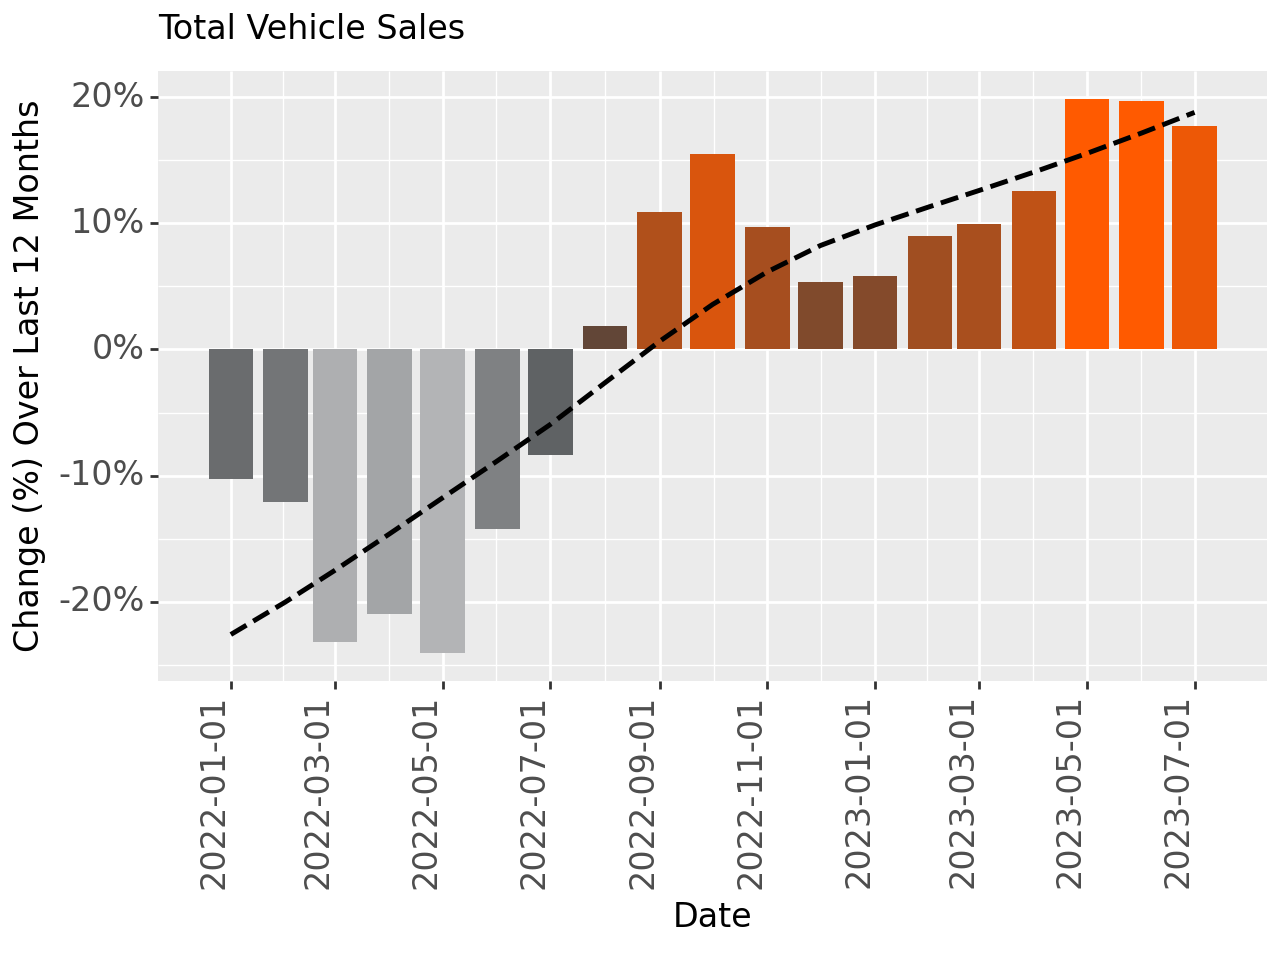

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [7]:
fred_plot

### Step 3: Generating report based on template <a class="anchor" id="third-bullet"></a>

#### Extracting Internal KPI Data from RedShift

#### Offline Version:  If running the query using ammpy taking too much time, alternative solution would be running the query in either Hubble or Datanet and download the result back to this notebook as .csv file

In [8]:
kpi_df = pd.read_csv('Auto KPI.csv',parse_dates=['activity_date'])

In [9]:
def internal_KPI(df, target_date,target_columns ,lag=12):
    
    for col in target_columns:
        col_name_ttm = col + '_ttm'
        col_name_ttm_change = col + '_ttm_pct'
        df[col_name_ttm] = df[col].shift(lag)
        df[col_name_ttm_change] = (df[col] - df[col_name_ttm]) / df[col_name_ttm]
    
    
    df.dropna(inplace=True)
    df = df[df['year_month'] > target_date]
    
    return df
    
def internal_KPI_plot(df, x,y_list,title_list, lag=12):
    
    kpi_plot_list = []
    
    assert (len(y_list) == len(title_list)), 'Parameter y_list needs to have the same length as parameter title_list !'
    
    
    for idx, y in enumerate(y_list):
        kpi_plot = ggplot(df, aes(x=x,y=y, fill=y))\
        + geom_bar(stat = "identity", position = "dodge")\
        + geom_smooth(linetype="dashed")\
        + ggtitle(title_list[idx])\
        + xlab('Date') + ylab('Change (%) Over Last' + str(lag) + ' Months') \
        + scale_y_continuous(labels=percent_format()) \
        + theme(legend_title=element_blank(),\
                legend_position = "none",\
                    text=element_text(size=12),\
                 axis_text_x=element_text(rotation=90, hjust=1))\
        + scale_fill_gradientn(colors = ["#B3B4B6","#3E4143", "#FF5A00"])
        
        kpi_plot_list.append(kpi_plot)
    
    return kpi_plot_list

In [10]:
 kpi_df['activity_date']

0        2019-01-02
1        2019-01-02
2        2019-01-02
3        2019-01-02
4        2019-01-02
            ...    
148007   2022-09-23
148008   2022-09-23
148009   2022-09-23
148010   2022-09-23
148011   2022-09-23
Name: activity_date, Length: 148012, dtype: datetime64[ns]

In [11]:
# Create Year_Month column
kpi_df['year_month'] = kpi_df['activity_date'].dt.to_period('M').apply(lambda r: r.start_time)

# Auto
kpi_df['total_impressions'] = kpi_df['video_impressions'] + kpi_df['firetv_impressions'] + \
kpi_df['display_impressions'] + kpi_df['dsp_impressions'] + kpi_df['audio_impressions'] + \
kpi_df['ott_impressions']

kpi_df = kpi_df[['year_month','total_impressions','dpv','brandsales']]
kpi_df_agg =\
kpi_df.groupby('year_month', as_index=False).agg({'total_impressions':sum, 'dpv':sum, 'brandsales':sum})


In [12]:
target_columns = list(kpi_df_agg.columns)[1:]

In [13]:
kpi_df_agg = internal_KPI(kpi_df_agg, target_date = '2020-11-01',\
                             target_columns = target_columns )

In [14]:
y_list = ['brandsales_ttm_pct','dpv_ttm_pct','total_impressions_ttm_pct']
title_list = ['Auto Total Sales','Auto Total Detail Page Views','Auto Total Impressions']

In [15]:
kpi_plot = internal_KPI_plot(kpi_df_agg, x='year_month', y_list=y_list, title_list = title_list, lag=12)

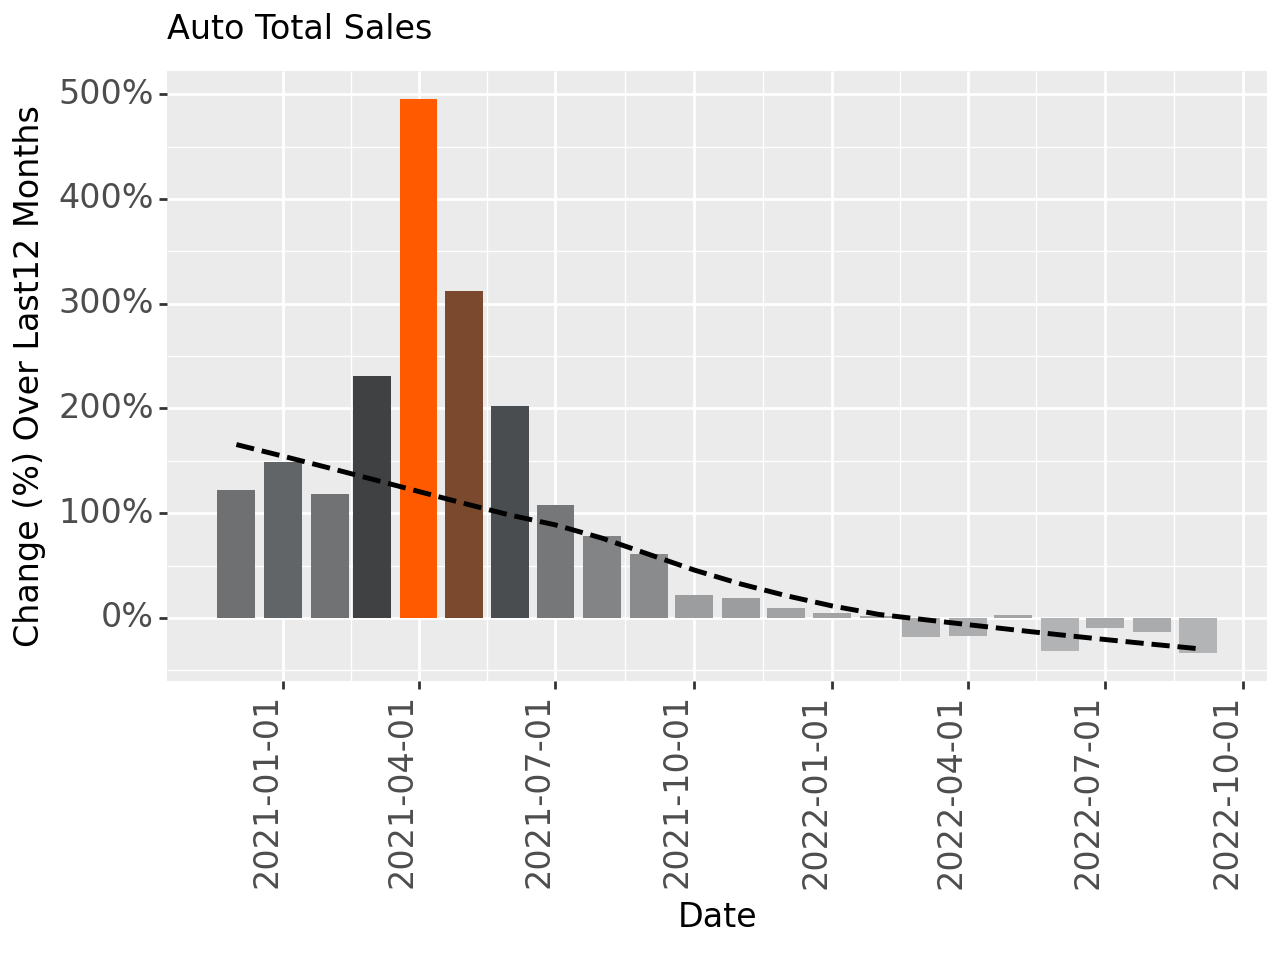

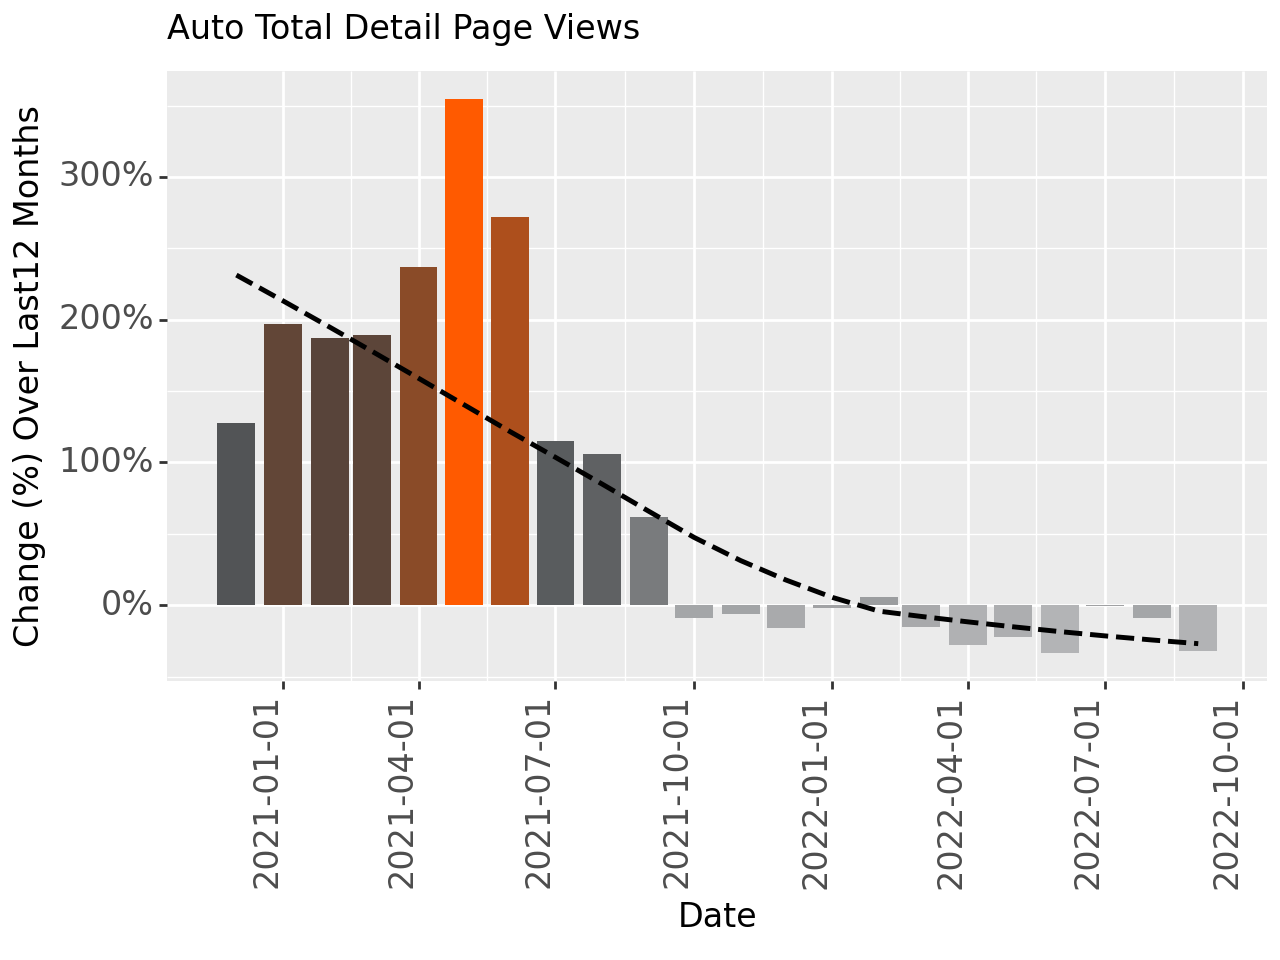

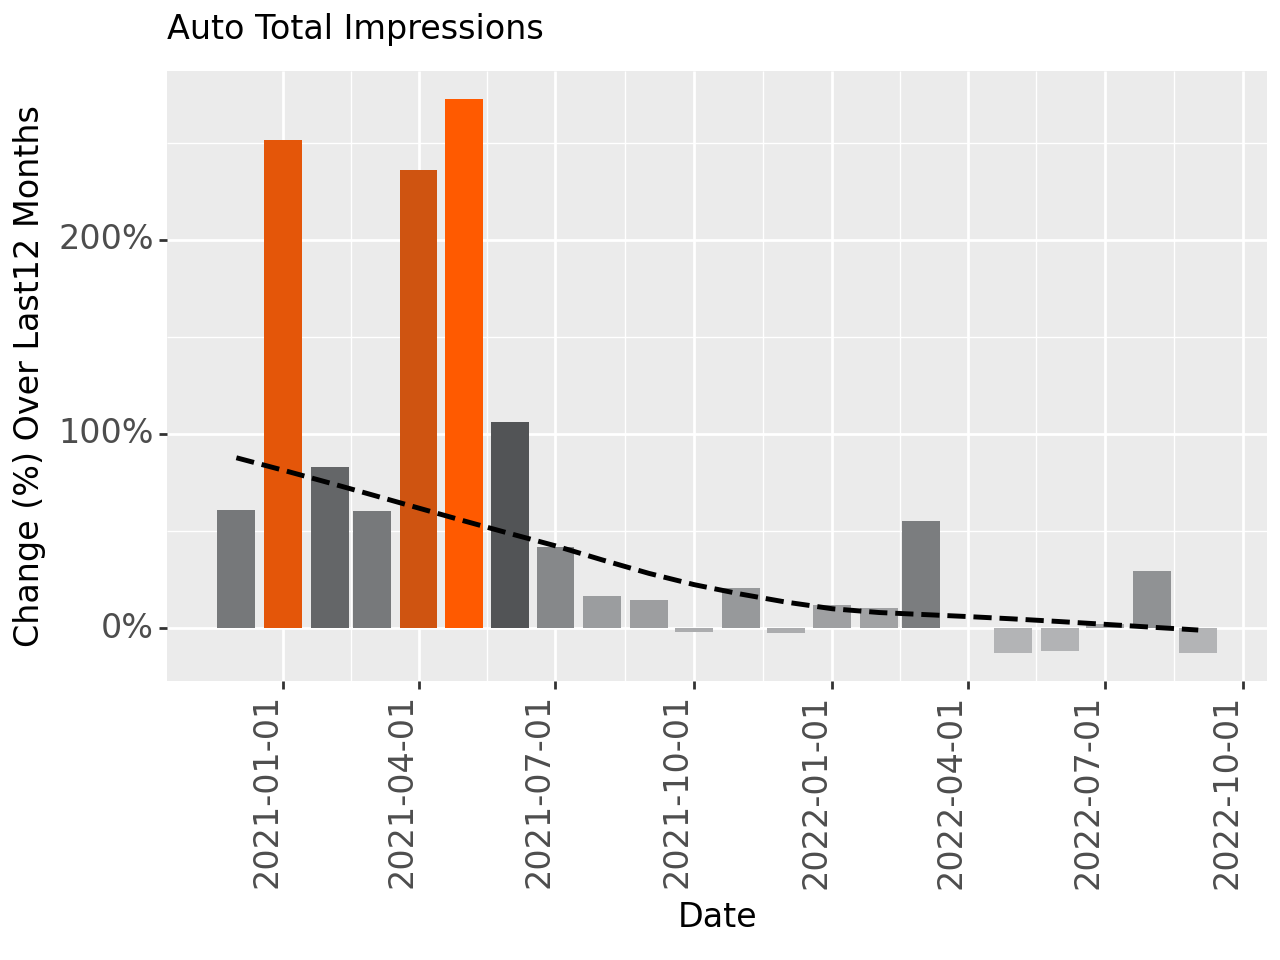

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [16]:
kpi_plot

#### Correlation Matrix

In [17]:
kpi_df_report = kpi_df_agg.filter(regex='ttm_pct') 

In [18]:
fred_df = pd.concat([df.filter(regex='ttm_change') for df in fred_list_transformed], axis=1)

In [19]:
kpi_df_report.reset_index(drop=True,inplace=True)
fred_df.reset_index(drop=True,inplace=True)

In [20]:
print(fred_df.columns)
print(kpi_df_report.columns)

Index(['CPI_ttm_change', 'Semi_PPI_ttm_change', 'CCI_ttm_change',
       'Auto_Sales_ttm_change'],
      dtype='object')
Index(['total_impressions_ttm_pct', 'dpv_ttm_pct', 'brandsales_ttm_pct'], dtype='object')


In [21]:
df_all = pd.concat([kpi_df_report, fred_df], axis=1, ignore_index=True)
df_all.columns = ['Consumer Price Index','Semiconductor PPI','Consumer Sentiment',\
                  'Total Vehicle Sales','Auto Impressions','Auto DPV','Auto Revenue']

<Axes: >

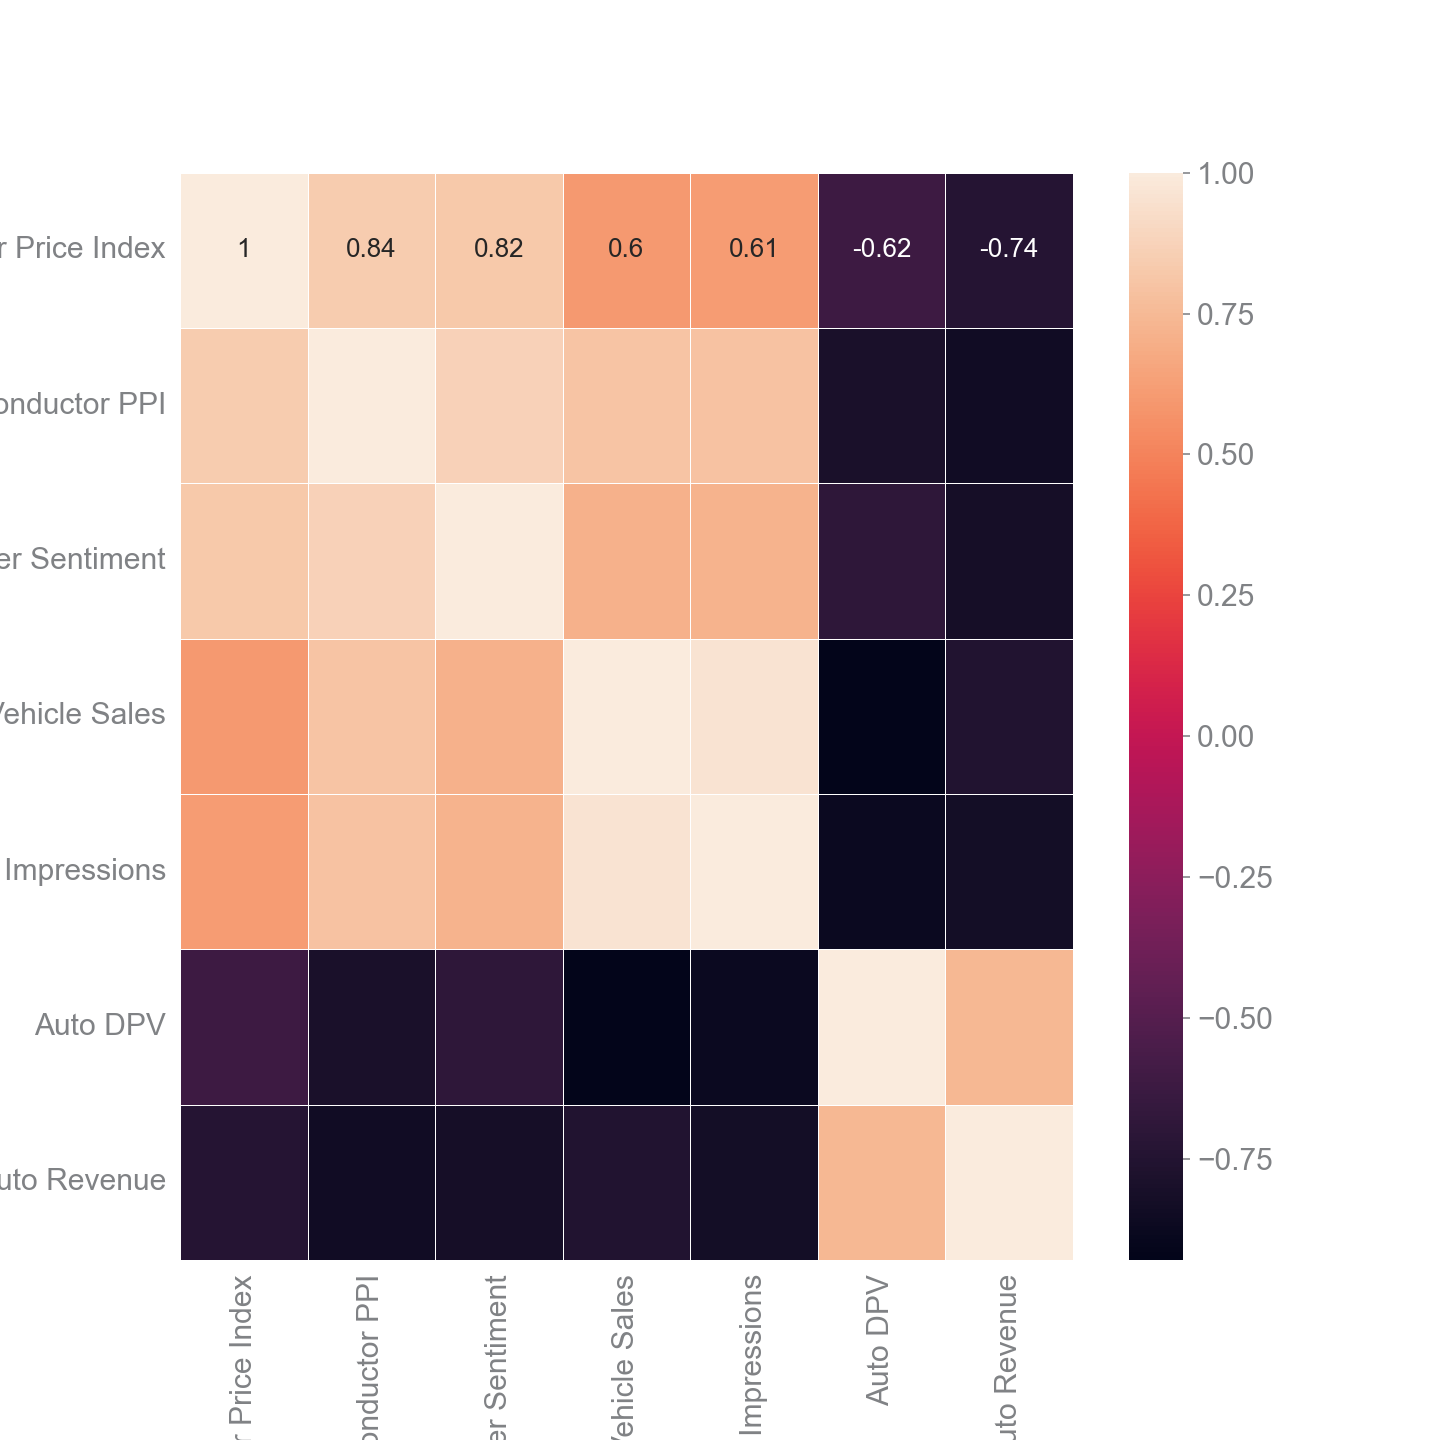

In [22]:
sns.heatmap(round(df_all.corr(),2), annot=True, linewidths=.5)